## Create a micromagnetic system

In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import matplotlib.pyplot as plt
import oommfc as oc
import random
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='svg'
thickness = 4e-9
cell = (4e-9, 4e-9, 4e-9)
p1 = (-100e-9, -100e-9, -thickness/2)
p2 = (100e-9, 100e-9, thickness/2)
region=df.Region(p1=p1,p2=p2)
mesh = df.Mesh(region=region, cell=cell)
system = mm.System(name='custom_skyrmion')
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + mm.Damping(alpha=0.3)
system.energy = mm.Exchange(A=1e-11)+mm.DMI(D=3.2e-3, crystalclass='Cnv_z')+mm.UniaxialAnisotropy(K=0.8e6, u=(0,0,1))

The skyrmion profile  can usually be written as follows<sup>1,2</sup>：
\begin{equation}
m_1=\sin \Theta \cos \Phi, \quad m_2=\sin \Theta \sin \Phi, \quad m_3=\cos \Theta\tag{1}
\end{equation}
where
\begin{equation}
\Phi=m \phi+\psi\tag{2}
\end{equation}
$m$ is the vorticity ($m$ = 1 for a skyrmion and $m$ = -1 for an antiskyrmion), and $\psi$ is a constant classifying type of skyrmions ($\psi$ = 0 or $\pi$ for Neel skyrmions and $\psi$=土$\pi$/2 for Bloch skyrmions).


<sup>1</sup> *Skyrmion dynamics in chiral ferromagnets under spin-transfer torque [PHYSICAL REVIEW B 92, 174405 (2015)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.174405)*

<sup>2</sup> *A theory on skyrmion size [Commun Phys 1, 31 (2018)](https://www.nature.com/articles/s42005-018-0029-0)*

### Take creating a Neel skyrmion as an example

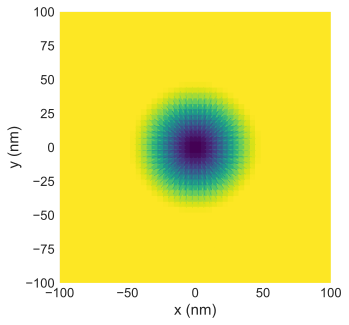

In [12]:
def neel_skyrmion(pos):
    R = 50e-9 #Skyrmion radius
    x, y = pos[0], pos[1]
    r = np.sqrt(x ** 2 + y ** 2) #The skyrmion center is located at (0, 0)
    phi = np.arctan2(y, x)
    phi_b = np.arctan2(y, x)
    
    k = np.pi / R
    
    if r < R :
        m = (-np.sin(k * r) * np.cos(phi_b), -np.sin(k * r) * np.sin(phi_b), -np.cos(k * r))
    else:
        m = (0, 0, 1)
    return m

system.m =  df.Field(mesh, dim=3, value=neel_skyrmion, norm=5.8e5)
fig=plt.figure(figsize=(5,5),dpi=100)
ax=fig.add_subplot(111)
system.m.z.plane('z').mpl.scalar(ax=ax,colorbar=False)
system.m.plane('z').mpl.vector(ax=ax,scale=1e7,colorbar=False)

### Bloch skyrmion

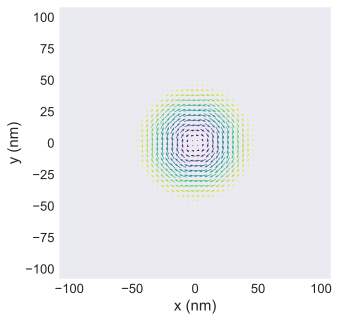

In [21]:
def Bloch_skyrmion(pos):
    R = 50e-9 #Skyrmion radius
    x, y = pos[0], pos[1]
    r = np.sqrt(x ** 2 + y ** 2) #The skyrmion center is located at (0, 0)
    phi = np.arctan2(y, x)+np.pi/2
    
    k = np.pi / R
    
    if r < R :
        m = (-np.sin(k * r) * np.cos(phi), -np.sin(k * r) * np.sin(phi), -np.cos(k * r))
    else:
        m = (0, 0, 1)
    return m

system.m =  df.Field(mesh, dim=3, value=Bloch_skyrmion, norm=5.8e5)
fig=plt.figure(figsize=(5,5),dpi=100)
ax=fig.add_subplot(111)

system.m.plane('z').mpl.vector(ax=ax,scale=2e7,colorbar=False)

The peculiar twists of the spins within the skyrmion imparts an elementary topological charge Q, defined as

\begin{equation}
Q=\frac{1}{4 \pi} \int \mathbf{m} \cdot\left(\frac{\partial \mathbf{m}}{\partial x} \times \frac{\partial \mathbf{m}}{\partial y}\right) d x d y\tag{3}
\end{equation}

For Neel skyrmion and Bloch skyrmion, their topological charges $Q$=土1. In addition, the scientists found a novel skyrmion named skyrmionium, also known as 2z-vortex or target skyrmion, which had the characteristic of zero topological number, and as a result, the movement of skyrmionium would not be influenced by Skyrmion Hall effeect in a racetrack.

Skyrmionium can be created in ubermag in the following form

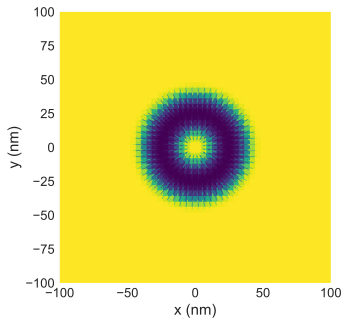

In [24]:
def neel_skyrmionium(pos):
    R = 50e-9 #Skyrmionium radius
    x, y = pos[0], pos[1]
    r = np.sqrt(x ** 2 + y ** 2) #The skyrmion center is located at (0, 0)
    phi = np.arctan2(y, x)
    phi_b = np.arctan2(y, x)
    
    k = np.pi / R
    
    if r < R :
        m = (-np.sin(k * r) * np.cos(phi_b), -np.sin(k * r) * np.sin(phi_b), np.cos(2* k * r))
    else:
        m = (0, 0, 1)
    return m

system.m =  df.Field(mesh, dim=3, value=neel_skyrmionium, norm=5.8e5)
fig=plt.figure(figsize=(5,5),dpi=100)
ax=fig.add_subplot(111)
system.m.z.plane('z').mpl.scalar(ax=ax,colorbar=False)
system.m.plane('z').mpl.vector(ax=ax,scale=1e7,colorbar=False)

The above method gives the method of customizing the skyrmion type, position and size, but in the actual micromagnetic problem, I prefer to establish a magnetic bubble and then obtain a skyrmion through relaxation, so that the skyrmion obtained under this micromagnetic condition is stable.As shown below：

In [25]:
def initial_state(pos):
    x, y = pos[0], pos[1]
    if (x**2+y**2)**0.5<50e-9:
        m = (0,0,-1)
    else:
        m = (0, 0, 1)
    return m

system.m =  df.Field(mesh, dim=3, value=initial_state, norm=5.8e5)
ad = oc.MinDriver()
ad.drive(system)


Running OOMMF (ExeOOMMFRunner)[2022/09/19 21:45]... (3.0 s)


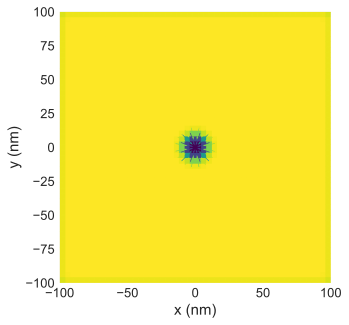

In [26]:
fig=plt.figure(figsize=(5,5),dpi=100)
ax=fig.add_subplot(111)
system.m.z.plane('z').mpl.scalar(ax=ax,colorbar=False)
system.m.plane('z').mpl.vector(ax=ax,scale=1e7,colorbar=False)